# Building NLP Applications with Hugging Face

About this project:
- **sentiment analysis** (i.e. categorizing text as negative or positive);
- **text embedding** (i.e. transforming a piece of text into a numerical, n-dimensional vector, representation);
- **semantic search** (i.e. matching a query with the most appropriate result based on embeddings);

The dataset comes from "Rent the Runway" [link](https://cseweb.ucsd.edu//~jmcauley/datasets.html#clothing_fit) and is comprised of user reviews on clothing items, their ratings on fit, and other metadata about the user (i.e. gender, height, size, age, reason for renting) and the item (i.e. category).


## Task 0: Setup

In [ ]:
# Import the other required packages and modules.
import pandas as pd
import numpy as np
import datetime
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search

# From the IPython.display package, import display and Markdown
from IPython.display import display, Markdown

## Task 1: Import the Runway Data

In [ ]:
# Read the data from runway.csv
runway = pd.read_csv("runway.csv", parse_dates=['review_date'])

# Print the column info
print(runway.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1506 non-null   int64         
 1   item_id      1506 non-null   int64         
 2   rating       1506 non-null   int64         
 3   rented for   1506 non-null   object        
 4   review_text  1506 non-null   object        
 5   category     1506 non-null   object        
 6   height       1503 non-null   object        
 7   size         1506 non-null   int64         
 8   age          1500 non-null   float64       
 9   review_date  1506 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 117.8+ KB
None


## Task 2: Preprocessing the `review_text`

In [ ]:
# Remove the forward-slash character
runway['review_text_cleaned'] = runway['review_text'].str.replace(r"\/", "")

# Remove punctuation
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.translate(string.punctuation)

# Remove digits
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\d+","")

# Remove running spaces
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\s{2,}","")

# Make the text lowercase
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.lower()

## Task 3: Sentiment Analysis on `review_text_cleaned`

In [ ]:
model = "distilbert-base-uncased-finetuned-sst-2-english"

# Instantiate the new pipeline() object for sentiment analysis. Include the model defined above as the model input.
sentimentAnalysis = pipeline('sentiment-analysis', model=model)

# Run sentiment analysis on the cleaned review text.
sent_analysis_output = sentimentAnalysis(list(runway['review_text_cleaned']))

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


## Task 4: Histogram of Sentiment Score

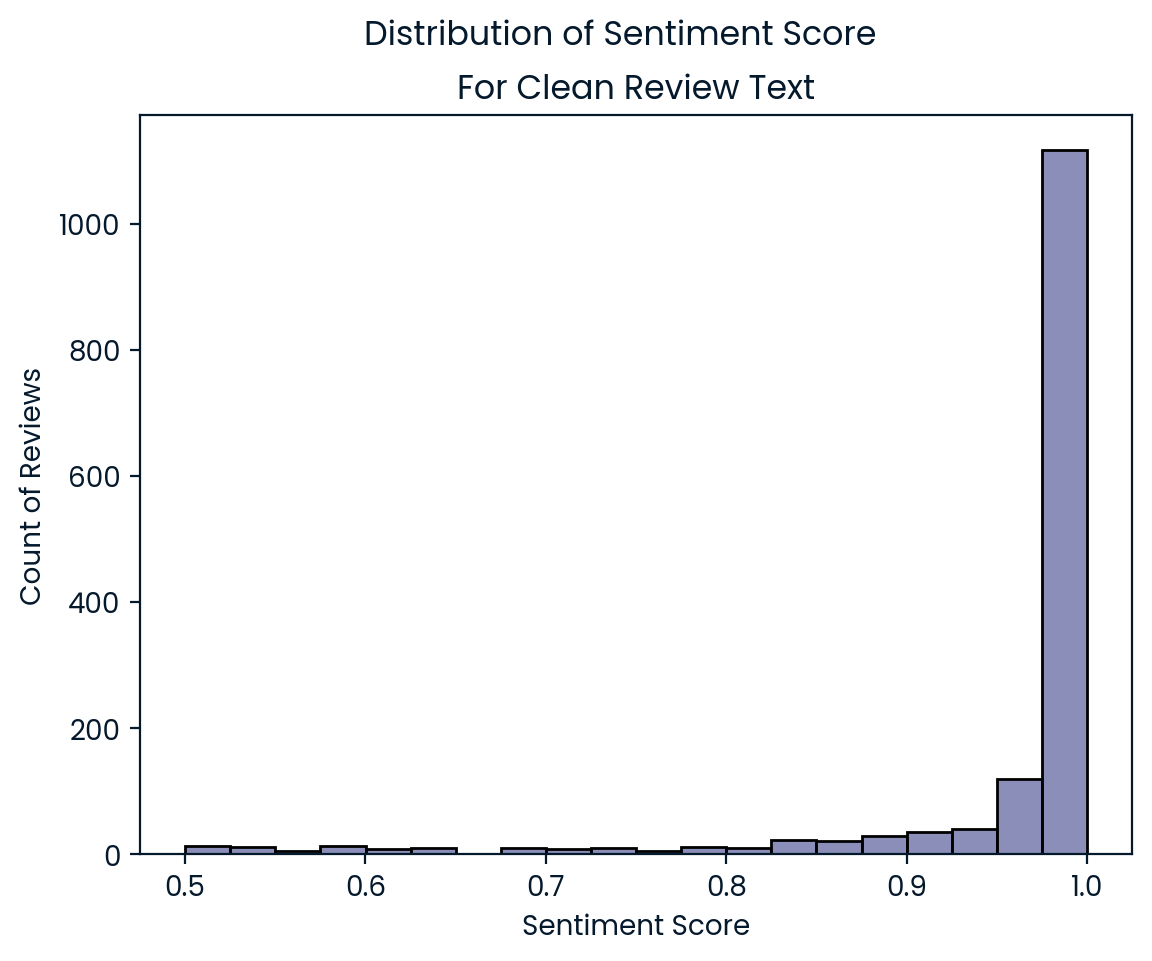

In [ ]:
# Parse out the two pieces of output from sent_analysis_output - "label" and "score".
runway['clean_sentiment_category'] = [s['label'] for s in sent_analysis_output]
runway['clean_sentiment_score'] = [s['score'] for s in sent_analysis_output]

# Create the first histogram using the built-in Pandas histogram method.
sns.histplot(data=runway, x='clean_sentiment_score', bins=20)
plt.suptitle("Distribution of Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Count of Reviews")
plt.title("For Clean Review Text")
plt.show()

## Task 5: Sentiment Over the Years

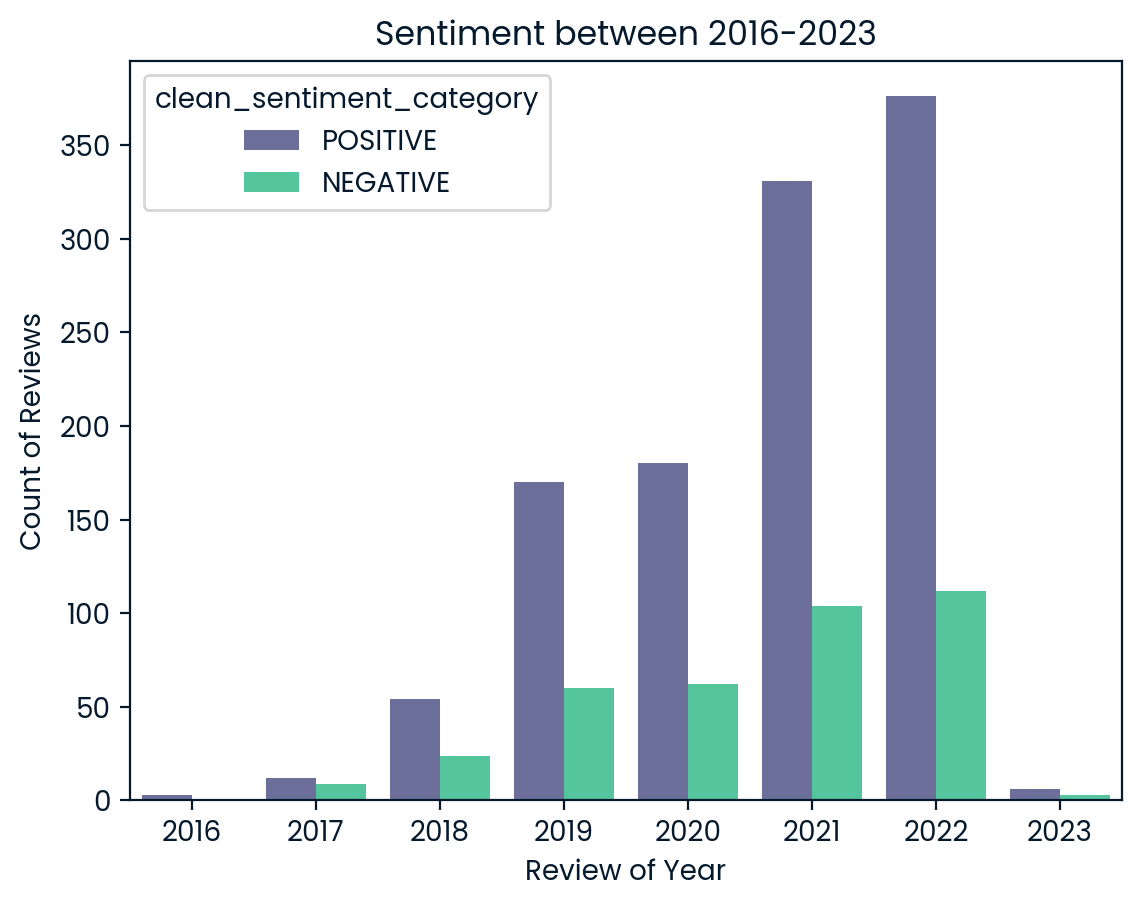

In [ ]:
# Create a new column called "year" which is the year of the "review_date".
runway['year'] = runway['review_date'].dt.year

# Create a new dataframe of review counts by "year" and "cleaned_sentiment_category".
chart_data = runway.groupby(['year','clean_sentiment_category'], as_index=False)['user_id'].count()
chart_data.columns = ['year','clean_sentiment_category','cnt']

# Create a bar plot showing the count of reviews for each sentiment category over the years.
sns.barplot(data=chart_data, x='year', y='cnt', hue='clean_sentiment_category', errorbar=None)
plt.title('Sentiment between 2016-2023')
plt.xlabel('Review of Year')
plt.ylabel('Count of Reviews')
plt.show()

## Task 6: Does Cleaning Text Matter?

In [ ]:
# Create a new sentiment analysis output for "review_text".
sent_analysis_2 = sentimentAnalysis(list(runway['review_text']))

# Parse the output into "sentiment_category" and "sentiment_score".
runway['sentiment_category'] = [s['label'] for s in sent_analysis_2]
runway['sentiment_score'] = [s['score'] for s in sent_analysis_2]

# Print the confusion matrix comparing the two sentiment category outputs.
display(pd.crosstab(runway['clean_sentiment_category'], runway['sentiment_category']))

sentiment_category,NEGATIVE,POSITIVE
clean_sentiment_category,,
NEGATIVE,373,1
POSITIVE,2,1130


## Task 7: Embeddings

In [ ]:
model_id = "sentence-transformers/all-MiniLM-L6-v2"

# Instantiate a new SentenceTransformer object.
model = SentenceTransformer(model_id)

# Generate the embeddings for the "rented for" column.
embeddings = model.encode(list(runway['rented for']))

print(embeddings.shape)

(1506, 384)


## Task 8: Clustering

In [ ]:
# Import TSNE
from sklearn.manifold import TSNE

# Instantiate a new TSNE object.
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random",learning_rate=200)

# Generate the tsne dimensions using the saved embeddings.
tsne_dims = tsne.fit_transform(embeddings)

print(tsne_dims.shape)

(1506, 2)


## Task 9: Visualizing the Clusters

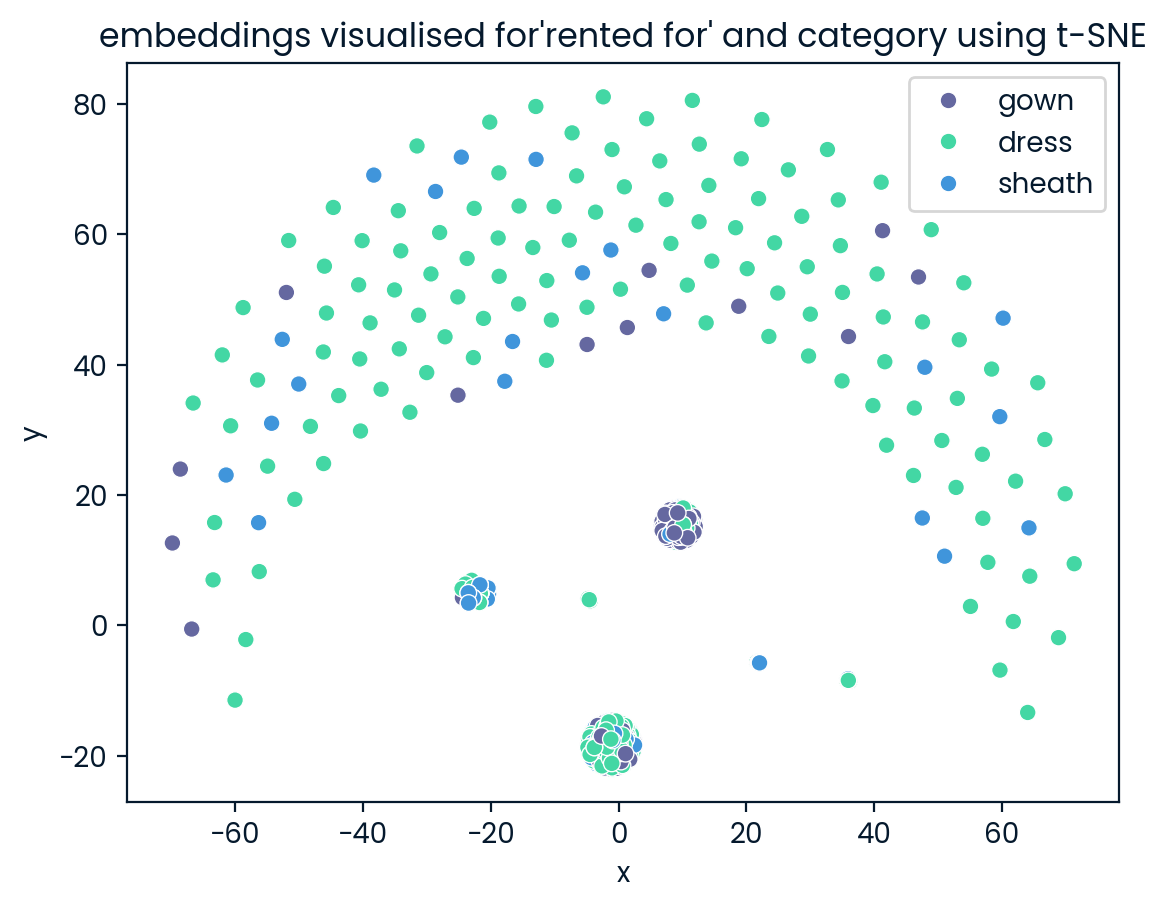

In [ ]:
# Parse out the x and y dimensions from the tsne output.
runway['x'] = [x for x, y in tsne_dims]
runway['y'] = [y for x, y in tsne_dims]

# Create the scatterplot
sns.scatterplot(data = runway, x="x", y="y", hue = "category")
plt.legend()
plt.title("embeddings visualised for'rented for' and category using t-SNE")
plt.show()

## Task 10: Semantic Search

In [ ]:
# Define query
query = "a gorgeous and flattering dress"

# Embed query
query_emb = model.encode(query, convert_to_tensor=True)

# Calculate similarity between query and item embeddings
hits = semantic_search(query_emb, embeddings, top_k=3)

# Print top similar items
for hits in hits[0]:
    idx = hits['corpus_id']
    print(
        "ITEM ID: ", runway.iloc[idx]['item_id'],
        "; RENTED FOR: ", runway.iloc[idx]['rented for'],
        "; REVIEW: ", runway.iloc[idx]['review_text']
    )

ITEM ID:  1498329 ; RENTED FOR:  wedding ; REVIEW:  the dress was gorgeous but unfortunately i was unable to wear it due to some quality issues which the renttherunway team was excellent at handlingi would recommend going upsizes from your usual dress size if you have a larger bustit also runs on the long side imand even withinch heels it dragged a little too much for my preferencethe colours are rich and true to the picture the fabric is forgiving when it comes to wrinkles so its a dress that travels very well
ITEM ID:  1879504 ; RENTED FOR:  wedding ; REVIEW:  this dress was greatit fit really well and was very comfortablethe only negative is that the length is a little odd so it made walking up stairs and getting into the car a little difficultimlbs and the medium fit perfectly
ITEM ID:  652189 ; RENTED FOR:  wedding ; REVIEW:  even though it was lined with satin this was a light beachy dress that was still formal enough for this casual beach weddingitsbackless though so you cant we

In [ ]:
print(runway.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_id                   1506 non-null   int64         
 1   item_id                   1506 non-null   int64         
 2   rating                    1506 non-null   int64         
 3   rented for                1506 non-null   object        
 4   review_text               1506 non-null   object        
 5   category                  1506 non-null   object        
 6   height                    1503 non-null   object        
 7   size                      1506 non-null   int64         
 8   age                       1500 non-null   float64       
 9   review_date               1506 non-null   datetime64[ns]
 10  review_text_cleaned       1506 non-null   object        
 11  clean_sentiment_category  1506 non-null   object        
 12  clean_sentiment_scor

## Task 11: Generate New Marketing Material

In [ ]:
# Instantiate the pipeline for generating text
generator = pipeline(model='gpt2')

# Pre-defined prompt
prompt = "New for this winter season, a lovely dress that"

# Use the prompt as input to the generator to return output.
output = generator(prompt, num_return_sequences = 1, return_full_text = False)

# Print the generated text.
print("New marketing Campaign: ", prompt, output[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


New marketing Campaign:  New for this winter season, a lovely dress that  I bought in October. It includes a neckline and embroidered bust with white lace trimmed and silk fabric with blue pleat lace. This will be the first time that I have worn silk lace,
